## Importing required libraries for project

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from dateutil import parser
from datetime import datetime, timedelta
from xgboost import XGBRegressor, XGBClassifier
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

## Loading data set

In [2]:
df=pd.read_csv("../data/raw/traffic_raw.csv")

## Displaying data frame first 5 rows

In [3]:
df.head()

,traffic_id,date_time,city,area,vehicle_count,road_condition,avg_speed_kmh,congestion_level,accident_count,visibility_m
0,NaN,2024-01-01 00:00,London,Camden,390.0,Snowy,NaN,Low,0.000000,10000.000000
1,9002.0,2024-01-01 02:00,London,Camden,49.0,Dry,NaN,Low,NaN,10000.000000
2,9003.0,2024-01-01 04:00,London,NaN,432.0,Snowy,48.83,Low,59.201303,120016.566405
3,9004.0,2024-01-01 06:00,London,Islington,884.0,Dry,83.27,Low,0.000000,120024.415191
4,9005.0,2024-01-01 08:00,London,Greenwich,3382.0,Dry,NaN,NaN,0.000000,10000.000000


## Displaying data set last 5 rows

In [4]:
df.tail()

,traffic_id,date_time,city,area,vehicle_count,road_condition,avg_speed_kmh,congestion_level,accident_count,visibility_m
5495,10575.0,2024-05-11 04:00,London,Islington,0.0,Dry,65.05,Low,0.0,10000.000000
5496,NaN,NaN,London,Camden,2701.0,Dry,40.15,Medium,0.0,120002.874615
5497,10052.0,28/03/2024 02PM,London,NaN,1163.0,Dry,83.83,Low,0.0,10000.000000
5498,11730.0,15/08/2024 10AM,London,Greenwich,1102.0,NaN,64.92,Low,0.0,10000.000000
5499,12940.0,2024-11-24 06:00,NaN,Greenwich,2444.0,Dry,50.87,Medium,NaN,10000.000000


## Displaying data frame:
### a) column names
### b) Number of non-null rows
### c) Data type of each column
### d) memory usage

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500 entries, 0 to 5499
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   traffic_id        4925 non-null   float64
 1   date_time         4918 non-null   object 
 2   city              4962 non-null   object 
 3   area              4971 non-null   object 
 4   vehicle_count     4935 non-null   float64
 5   road_condition    4893 non-null   object 
 6   avg_speed_kmh     4948 non-null   float64
 7   congestion_level  4988 non-null   object 
 8   accident_count    4930 non-null   float64
 9   visibility_m      4930 non-null   float64
dtypes: float64(5), object(5)
memory usage: 429.8+ KB


## Displaying some statistics about numerical features in data set

In [6]:
df.describe()

,traffic_id,vehicle_count,avg_speed_kmh,accident_count,visibility_m
count,4925.000000,4935.000000,4948.000000,4930.000000,4930.000000
mean,11626.267614,4010.525383,66.353590,3.281388,17050.708787
std,1511.385265,7232.602443,105.738193,13.071876,24390.016105
min,9002.000000,0.000000,-25.979507,-4.891917,10000.000000
25%,10311.000000,884.000000,24.677500,0.000000,10000.000000
50%,11637.000000,1824.000000,44.295000,0.000000,10000.000000
75%,12927.000000,2799.000000,67.862500,0.000000,10000.000000
max,14250.000000,30024.948593,524.961703,74.718433,120024.875985


# (1) Data Cleaning

# Cleaning order:
## 1. Handling nulls (missing values) & Inconsistent Values
## 2. Adjusting columns data types (formats)
## 3. Removing duplicated rows
## 4. Handling outliers

# <hr style="height:3px; border:none; background:#4a90e2;">

# <div style="background:#f2f2f2; padding:12px; border-left:5px solid #4a90e2;">
#  <h3>📌 1. Handling nulls (missing values) & Inconsistent Values </h3>
# </div>

# <hr style="height:3px; border:none; background:#4a90e2;">

## a) Pattern Based cleaning

## I- Problems in "traffic_id" column:
###  574 rows in "traffic_id" column have null values
###  462 rows in "traffic_id" column with duplicated values

# <hr style="height:3px; border:none; background:#4a90e2;">

## Imputation strategy:
### Set duplicated traffic_id as nulls/missing values (with keeping traffic_id first occurrence)
### Impute each missing value (even original null or resulted from setting duplicated id as null) with value of :
### [traffic_id directly before this null + 1] , as this column follows a pattern

In [7]:
def clean_traffic_id(df):

    # Create a copy to avoid modifying the original
    df_cleaned = df.copy()
    
    # Step 1: Mark duplicates as NaN (keep first occurrence)
    duplicates_mask = df_cleaned['traffic_id'].duplicated(keep='first')
    df_cleaned.loc[duplicates_mask, 'traffic_id'] = np.nan
    
    # Step 2: Impute all NaN values with previous id + 1
    for i in range(len(df_cleaned)):
        if pd.isna(df_cleaned.loc[i, 'traffic_id']):
            if i == 0:
                # If first row is NaN, start with 9001
                df_cleaned.loc[i, 'traffic_id'] = 9001
            else:
                # Use previous id + 1
                df_cleaned.loc[i, 'traffic_id'] = df_cleaned.loc[i-1, 'traffic_id'] + 1
    
    # Step 3: Convert to integer type
    df_cleaned['traffic_id'] = df_cleaned['traffic_id'].astype(int)
    
    return df_cleaned

## Displaying data set after cleaning traffic_id column from nulls and duplicated values

In [8]:
df_stage_1=clean_traffic_id(df)
df_stage_1

,traffic_id,date_time,city,area,vehicle_count,road_condition,avg_speed_kmh,congestion_level,accident_count,visibility_m
0,9001,2024-01-01 00:00,London,Camden,390.0,Snowy,NaN,Low,0.000000,10000.000000
1,9002,2024-01-01 02:00,London,Camden,49.0,Dry,NaN,Low,NaN,10000.000000
2,9003,2024-01-01 04:00,London,NaN,432.0,Snowy,48.83,Low,59.201303,120016.566405
3,9004,2024-01-01 06:00,London,Islington,884.0,Dry,83.27,Low,0.000000,120024.415191
4,9005,2024-01-01 08:00,London,Greenwich,3382.0,Dry,NaN,NaN,0.000000,10000.000000
...,...,...,...,...,...,...,...,...,...,...
5495,14496,2024-05-11 04:00,London,Islington,0.0,Dry,65.05,Low,0.000000,10000.000000
5496,14497,NaN,London,Camden,2701.0,Dry,40.15,Medium,0.000000,120002.874615
5497,14498,28/03/2024 02PM,London,NaN,1163.0,Dry,83.83,Low,0.000000,10000.000000
5498,14499,15/08/2024 10AM,London,Greenwich,1102.0,NaN,64.92,Low,0.000000,10000.000000


# II- Problems in "city" column:
## 537 rows in "city" column have null values

# <hr style="height:3px; border:none; background:#4a90e2;">

## Imputation strategy:
### Impute each null/missing value by "London" value [as this column has only 1 value which is london]

In [9]:
def clean_city(df):
    
    # Create a copy to avoid modifying the original
    df_cleaned = df.copy()
    
    # Impute null values with "London"
    df_cleaned['city'] = df_cleaned['city'].fillna('London')
    
    return df_cleaned

## Displaying data set after cleaning city column from nulls

In [10]:
df_stage_2=clean_city(df_stage_1)
df_stage_2

,traffic_id,date_time,city,area,vehicle_count,road_condition,avg_speed_kmh,congestion_level,accident_count,visibility_m
0,9001,2024-01-01 00:00,London,Camden,390.0,Snowy,NaN,Low,0.000000,10000.000000
1,9002,2024-01-01 02:00,London,Camden,49.0,Dry,NaN,Low,NaN,10000.000000
2,9003,2024-01-01 04:00,London,NaN,432.0,Snowy,48.83,Low,59.201303,120016.566405
3,9004,2024-01-01 06:00,London,Islington,884.0,Dry,83.27,Low,0.000000,120024.415191
4,9005,2024-01-01 08:00,London,Greenwich,3382.0,Dry,NaN,NaN,0.000000,10000.000000
...,...,...,...,...,...,...,...,...,...,...
5495,14496,2024-05-11 04:00,London,Islington,0.0,Dry,65.05,Low,0.000000,10000.000000
5496,14497,NaN,London,Camden,2701.0,Dry,40.15,Medium,0.000000,120002.874615
5497,14498,28/03/2024 02PM,London,NaN,1163.0,Dry,83.83,Low,0.000000,10000.000000
5498,14499,15/08/2024 10AM,London,Greenwich,1102.0,NaN,64.92,Low,0.000000,10000.000000


## III- Problems in "date_time" column:
### 3263 rows have inconsistent date format ex:
### 2024-01-01T10:00Z (ISO format of date)
### 02/01/2024 06AM (12-hour format date)
###  904 rows in "date_time" column are duplicated
###  583 rows in "date_time" column are directly null values
###  27 rows in "date_time" column have "TBD" (To Be Determined) values
###  16 rows in "date_time" column have "Unknown" values
###  13 rows in "date_time" column have wrong values , ex: 2099-13-40 25:61 

# <hr style="height:3px; border:none; background:#4a90e2;">

## Imputation strategy:
### Unify the format of all dates into the standard date format which is:
###  "YYYY-MM-DD HH:MM"  --> ex: 2024-01-15 08:00
### Set rows of "TBD" values into missing values
### Set rows of "Unknown" values into missing values
### Set rows of wrong date values (ex:2099-13-40 25:61 ) into into missing values 

In [11]:
def clean_date_time_part_1(df):

    # Create a copy to avoid modifying the original
    df_cleaned = df.copy()
    
    # Step a & b: Replace "TBD" and "Unknown" with NaN
    df_cleaned['date_time'] = df_cleaned['date_time'].replace(['TBD', 'Unknown'], np.nan)
    
    # Step c & d: Parse and validate dates, set invalid ones to NaN
    def parse_and_format_date(date_str):
        if pd.isna(date_str):
            return np.nan
        
        try:
            # Convert to string if not already
            date_str = str(date_str).strip()
            
            # Try to parse the date using dateutil parser (handles multiple formats)
            parsed_date = parser.parse(date_str, dayfirst=False)
            
            # Validate the parsed date (check for logical values)
            if (parsed_date.year < 1900 or parsed_date.year > 2100 or
                parsed_date.month < 1 or parsed_date.month > 12 or
                parsed_date.day < 1 or parsed_date.day > 31 or
                parsed_date.hour < 0 or parsed_date.hour > 23 or
                parsed_date.minute < 0 or parsed_date.minute > 59):
                return np.nan
            
            # Format to "YYYY-MM-DD HH:MM"
            return parsed_date.strftime("%Y-%m-%d %H:%M")
        
        except (ValueError, parser.ParserError):
            # If parsing fails, return NaN
            return np.nan
    
    # Apply the parsing function to each row
    df_cleaned['date_time'] = df_cleaned['date_time'].apply(parse_and_format_date)
    
    return df_cleaned

## Display data set after cleaning date_time column from :
### null values
### TBD values 
### wrong values 
### Unknown values
### Inconsistent values 
### [Partially]

In [12]:
df_stage_3=clean_date_time_part_1(df_stage_2)
df_stage_3

,traffic_id,date_time,city,area,vehicle_count,road_condition,avg_speed_kmh,congestion_level,accident_count,visibility_m
0,9001,2024-01-01 00:00,London,Camden,390.0,Snowy,NaN,Low,0.000000,10000.000000
1,9002,2024-01-01 02:00,London,Camden,49.0,Dry,NaN,Low,NaN,10000.000000
2,9003,2024-01-01 04:00,London,NaN,432.0,Snowy,48.83,Low,59.201303,120016.566405
3,9004,2024-01-01 06:00,London,Islington,884.0,Dry,83.27,Low,0.000000,120024.415191
4,9005,2024-01-01 08:00,London,Greenwich,3382.0,Dry,NaN,NaN,0.000000,10000.000000
...,...,...,...,...,...,...,...,...,...,...
5495,14496,2024-05-11 04:00,London,Islington,0.0,Dry,65.05,Low,0.000000,10000.000000
5496,14497,NaN,London,Camden,2701.0,Dry,40.15,Medium,0.000000,120002.874615
5497,14498,2024-03-28 14:00,London,NaN,1163.0,Dry,83.83,Low,0.000000,10000.000000
5498,14499,2024-08-15 10:00,London,Greenwich,1102.0,NaN,64.92,Low,0.000000,10000.000000


## Function goal:
### Remove duplicated dates (keep first occurrence only)
### Impute nulls (whether these values are originalyy nulls or resulted from setting Unknown values & TBD values & wrong dates by nulls)

# <hr style="height:3px; border:none; background:#4a90e2;">

## Imputation strategy:
### Each day in data set has 12 dates , as weather measurement is taken for each day every 2 hours
### function will get both first date and last date in this column
### it will generate list of dates for all days between first date (included) and last date (included) , where also each day has 12 dates
### if there is a missing value , function will get its corresponding date in the generated dates list
### function will sort dates in the column in as ascending order after cleaning

In [13]:
def clean_date_time_part_2(df):
 
    # Create a copy to avoid modifying the original
    df_cleaned = df.copy()
    
    # Step a: Remove duplicates (set duplicates to NaN, keep first)
    # Convert to datetime for comparison
    df_cleaned['date_time_parsed'] = pd.to_datetime(df_cleaned['date_time'], 
                                                      format='%Y-%m-%d %H:%M', 
                                                      errors='coerce')
    
    # Mark duplicates as NaN
    duplicates_mask = df_cleaned['date_time_parsed'].duplicated(keep='first')
    df_cleaned.loc[duplicates_mask, 'date_time'] = np.nan
    df_cleaned.loc[duplicates_mask, 'date_time_parsed'] = pd.NaT
    
    # Step b: Get min and max dates (from non-null values)
    valid_dates = df_cleaned['date_time_parsed'].dropna()
    
    if len(valid_dates) == 0:
        # If no valid dates, return as is
        df_cleaned.drop('date_time_parsed', axis=1, inplace=True)
        return df_cleaned
    
    min_date = valid_dates.min()
    max_date = valid_dates.max()
    
    # Step c & d: Generate expected dates at 2-hour intervals
    # Set min_date to start of day at 00:00
    min_date = min_date.replace(hour=0, minute=0, second=0, microsecond=0)
    # Set max_date to end of day at 22:00
    max_date = max_date.replace(hour=22, minute=0, second=0, microsecond=0)
    
    # Generate all expected dates
    generated_dates = []
    current_date = min_date
    while current_date <= max_date:
        generated_dates.append(current_date)
        current_date += timedelta(hours=2)
    
    # Step e: Impute missing values with generated dates
    # Create a set of existing dates for quick lookup
    existing_dates_set = set(df_cleaned['date_time_parsed'].dropna())
    
    # Create a list of available generated dates (not already used)
    available_dates = [d for d in generated_dates if d not in existing_dates_set]
    
    # Fill nulls with available dates sequentially
    available_index = 0
    for i in range(len(df_cleaned)):
        if pd.isna(df_cleaned.loc[i, 'date_time']):
            if available_index < len(available_dates):
                df_cleaned.loc[i, 'date_time'] = available_dates[available_index].strftime('%Y-%m-%d %H:%M')
                available_index += 1
            else:
                # If we run out of generated dates, continue the pattern
                if len(generated_dates) > 0:
                    last_date = generated_dates[-1] + timedelta(hours=2 * (available_index - len(available_dates) + 1))
                    df_cleaned.loc[i, 'date_time'] = last_date.strftime('%Y-%m-%d %H:%M')
                    available_index += 1
    
    # Drop the temporary parsed column
    df_cleaned.drop('date_time_parsed', axis=1, inplace=True)
    
    # Final step: Sort by date_time from smallest to largest
    df_cleaned['date_time_temp'] = pd.to_datetime(df_cleaned['date_time'], 
                                                    format='%Y-%m-%d %H:%M', 
                                                    errors='coerce')
    df_cleaned = df_cleaned.sort_values('date_time_temp').reset_index(drop=True)
    df_cleaned.drop('date_time_temp', axis=1, inplace=True)
    
    return df_cleaned

## Displaying data set after cleaning date_time column from:
### null values
### TBD values 
### wrong values 
### Unknown values
### Inconsistent values 
### [totally]

In [14]:
df_stage_4=clean_date_time_part_2(df_stage_3)
df_stage_4

,traffic_id,date_time,city,area,vehicle_count,road_condition,avg_speed_kmh,congestion_level,accident_count,visibility_m
0,9001,2024-01-01 00:00,London,Camden,390.0,Snowy,NaN,Low,0.000000,10000.000000
1,9002,2024-01-01 02:00,London,Camden,49.0,Dry,NaN,Low,NaN,10000.000000
2,9003,2024-01-01 04:00,London,NaN,432.0,Snowy,48.83,Low,59.201303,120016.566405
3,9004,2024-01-01 06:00,London,Islington,884.0,Dry,83.27,Low,0.000000,120024.415191
4,9005,2024-01-01 08:00,London,Greenwich,3382.0,Dry,NaN,NaN,0.000000,10000.000000
...,...,...,...,...,...,...,...,...,...,...
5495,13531,2025-12-01 12:00,London,Westminster,2100.0,Dry,33.07,Medium,0.000000,10000.000000
5496,13532,2025-12-01 14:00,London,Southwark,2060.0,Dry,NaN,Low,7.604354,10000.000000
5497,13534,2025-12-01 18:00,London,Chelsea,4021.0,Snowy,3.00,High,0.000000,120014.099602
5498,13902,2025-12-02 10:00,London,Islington,2054.0,Dry,27.35,NaN,1.000000,10000.000000


## IV- Problems in "area" column:
### 529 rows with missing values (nulls)

# <hr style="height:3px; border:none; background:#4a90e2;">

## Imputation strategy:
### Replace each missing value (null) in this column using most repeated area in the same column

In [15]:
def clean_area(df):
    # Make a copy to avoid modifying the original dataframe
    df_cleaned = df.copy()
    
    # Compute mode of the area column
    mode_value = df_cleaned['area'].mode()[0]
    
    # Fill null values in area column with the mode
    df_cleaned['area'] = df_cleaned['area'].fillna(mode_value)
    
    return df_cleaned

## Display area column after cleaning it from missing values (nulls)

In [16]:
df_stage_5=clean_area(df_stage_4)
df_stage_5

,traffic_id,date_time,city,area,vehicle_count,road_condition,avg_speed_kmh,congestion_level,accident_count,visibility_m
0,9001,2024-01-01 00:00,London,Camden,390.0,Snowy,NaN,Low,0.000000,10000.000000
1,9002,2024-01-01 02:00,London,Camden,49.0,Dry,NaN,Low,NaN,10000.000000
2,9003,2024-01-01 04:00,London,Chelsea,432.0,Snowy,48.83,Low,59.201303,120016.566405
3,9004,2024-01-01 06:00,London,Islington,884.0,Dry,83.27,Low,0.000000,120024.415191
4,9005,2024-01-01 08:00,London,Greenwich,3382.0,Dry,NaN,NaN,0.000000,10000.000000
...,...,...,...,...,...,...,...,...,...,...
5495,13531,2025-12-01 12:00,London,Westminster,2100.0,Dry,33.07,Medium,0.000000,10000.000000
5496,13532,2025-12-01 14:00,London,Southwark,2060.0,Dry,NaN,Low,7.604354,10000.000000
5497,13534,2025-12-01 18:00,London,Chelsea,4021.0,Snowy,3.00,High,0.000000,120014.099602
5498,13902,2025-12-02 10:00,London,Islington,2054.0,Dry,27.35,NaN,1.000000,10000.000000


## V- Problems in "road_condition" column:
### 607 rows are missing values (nulls)

# <hr style="height:3px; border:none; background:#4a90e2;">

## Imputation strategy:
### Replace each missing value (null) in this column using most repeated road condition in the same column

In [17]:
def clean_road_condition(df):
    # Make a copy to avoid modifying the original dataframe
    df_cleaned = df.copy()
    
    # Compute mode of the area column
    mode_value = df_cleaned['road_condition'].mode()[0]
    
    # Fill null values in area column with the mode
    df_cleaned['road_condition'] = df_cleaned['road_condition'].fillna(mode_value)
    
    return df_cleaned

In [18]:
df_stage_6=clean_road_condition(df_stage_5)

## VI- Problems in "avg_speed_kmh" column and "accident_count" column:
### "avg_speed_kmh" column has 2 rows with negative values
### "accident_count" column has 49 rows with negative values

In [19]:
def fix_negative_values(df):
    df = df.copy()

    # Columns to fix
    cols_to_fix = ["accident_count", "avg_speed_kmh"]

    for col in cols_to_fix:
        df[col] = df[col].abs()   # Convert negative values to absolute

    return df

In [20]:
df_stage_6 = fix_negative_values(df_stage_6)

## Display road_condition column after cleaning it from missing values (nulls)
## Displaying whole data set after removine negative values from "accident_count" column and "accident_count" column

In [21]:
df_stage_6

,traffic_id,date_time,city,area,vehicle_count,road_condition,avg_speed_kmh,congestion_level,accident_count,visibility_m
0,9001,2024-01-01 00:00,London,Camden,390.0,Snowy,NaN,Low,0.000000,10000.000000
1,9002,2024-01-01 02:00,London,Camden,49.0,Dry,NaN,Low,NaN,10000.000000
2,9003,2024-01-01 04:00,London,Chelsea,432.0,Snowy,48.83,Low,59.201303,120016.566405
3,9004,2024-01-01 06:00,London,Islington,884.0,Dry,83.27,Low,0.000000,120024.415191
4,9005,2024-01-01 08:00,London,Greenwich,3382.0,Dry,NaN,NaN,0.000000,10000.000000
...,...,...,...,...,...,...,...,...,...,...
5495,13531,2025-12-01 12:00,London,Westminster,2100.0,Dry,33.07,Medium,0.000000,10000.000000
5496,13532,2025-12-01 14:00,London,Southwark,2060.0,Dry,NaN,Low,7.604354,10000.000000
5497,13534,2025-12-01 18:00,London,Chelsea,4021.0,Snowy,3.00,High,0.000000,120014.099602
5498,13902,2025-12-02 10:00,London,Islington,2054.0,Dry,27.35,NaN,1.000000,10000.000000


# <div style="background:#f2f2f2; padding:12px; border-left:5px solid #4a90e2;">
#  <h3>📌 2. Adjusting columns data types (formats) </h3>
# </div>

In [22]:
df_stage_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500 entries, 0 to 5499
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   traffic_id        5500 non-null   int64  
 1   date_time         5500 non-null   object 
 2   city              5500 non-null   object 
 3   area              5500 non-null   object 
 4   vehicle_count     4935 non-null   float64
 5   road_condition    5500 non-null   object 
 6   avg_speed_kmh     4948 non-null   float64
 7   congestion_level  4988 non-null   object 
 8   accident_count    4930 non-null   float64
 9   visibility_m      4930 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 429.8+ KB


## Problems in data types of data set features:

### date_time: expected data type --> [DateTime] {follows this format only "YYYY-MM-DD HH:MM" ex: 2024-01-15 08:00} , actual data type --> [object]
### city: expected data type --> [String] , actual data type --> [object]
### vehicle_count: expected data type  --> [Integer] , actual data type --> [float]
### road_condition: expected data type  --> [Category] , actual data type --> [object]
### congestion_level: expected data type  --> [Category] , actual data type --> [object]
### area: expected --> [String] data type , actual data type --> [object]
### accident_count: expected --> [Integer] , actual data type --> [float]
### visibility_m: expected --> [Integer] , actual data type --> [float]

In [23]:
def adjust_features_data_types(df: pd.DataFrame) -> pd.DataFrame:
    # ... (function body) ...
    
    # 1. date_time: expected --> [DateTime]
    df['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M', errors='coerce')

    dtype_mapping = {
        'city': pd.StringDtype(),
        'vehicle_count': pd.Int64Dtype(), # Nullable Integer
        'road_condition': 'category',
        'congestion_level': 'category',
        'area': pd.StringDtype(),
        'accident_count': pd.Int64Dtype(), # Nullable Integer
        'visibility_m': pd.Int64Dtype(), # Nullable Integer
    }

    for col, dtype in dtype_mapping.items():
        if col in df.columns:
            # Special handling for nullable integers to round float data before conversion
            if dtype == pd.Int64Dtype():
                df[col] = df[col].round(0).astype(dtype)
            else:
                df[col] = df[col].astype(dtype)

    return df

## Checking that all columns data types are correct

In [24]:
df_stage_7=adjust_features_data_types(df_stage_6)
df_stage_7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500 entries, 0 to 5499
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   traffic_id        5500 non-null   int64         
 1   date_time         5500 non-null   datetime64[ns]
 2   city              5500 non-null   string        
 3   area              5500 non-null   string        
 4   vehicle_count     4935 non-null   Int64         
 5   road_condition    5500 non-null   category      
 6   avg_speed_kmh     4948 non-null   float64       
 7   congestion_level  4988 non-null   category      
 8   accident_count    4930 non-null   Int64         
 9   visibility_m      4930 non-null   Int64         
dtypes: Int64(3), category(2), datetime64[ns](1), float64(1), int64(1), string(2)
memory usage: 371.1 KB


## Determining the type of correlation between each pair of these features:  [temperature_c , weather_condition,season , wind_speed_kmh , humidity,rain_mm , visibility_m , air_pressure_hpa]
### To determine best algorithm for machine learning imputation

In [25]:
def analyze_correlation_types(df):

    # Create a copy to avoid modifying original data
    data = df.copy()
    
    # Store results
    correlation_results = {}
    
    # Get feature names
    features = list(data.columns)
    
    # Check if expected features exist
    expected_features = ['vehicle_count', 'avg_speed_kmh', 'accident_count', 
                        'visibility_m', 'congestion_level']
    
    for feat in expected_features:
        if feat not in features:
            print(f"Warning: '{feat}' not found in DataFrame columns")
            print(f"Available columns: {features}")
            return
    
    # Identify numerical and categorical features
    numerical_features = ['vehicle_count', 'avg_speed_kmh', 'accident_count', 'visibility_m']
    categorical_features = ['congestion_level']
    
    # Prepare encoded version of categorical variable
    if data['congestion_level'].dtype == 'object' or data['congestion_level'].dtype.name == 'category':
        le = LabelEncoder()
        congestion_encoded = le.fit_transform(data['congestion_level'])
    else:
        congestion_encoded = data['congestion_level'].values
    
    # Function to determine correlation type
    def determine_correlation_type(corr_value, corr_method, p_value=None):
        """Helper function to interpret correlation results"""
        if p_value is not None and p_value > 0.05:
            return "No significant correlation", corr_value, p_value
        
        abs_corr = abs(corr_value)
        
        if corr_method == 'pearson':
            if abs_corr >= 0.7:
                corr_strength = "Strong"
                corr_type = "Linear"
            elif abs_corr >= 0.3:
                corr_strength = "Moderate"
                corr_type = "Linear"
            elif abs_corr > 0.1:
                corr_strength = "Weak"
                corr_type = "Linear"
            else:
                corr_strength = "Very weak/None"
                corr_type = "Linear"
                
        elif corr_method in ['spearman', 'kendall']:
            if abs_corr >= 0.7:
                corr_strength = "Strong"
                corr_type = "Non-linear (monotonic)"
            elif abs_corr >= 0.3:
                corr_strength = "Moderate"
                corr_type = "Non-linear (monotonic)"
            elif abs_corr > 0.1:
                corr_strength = "Weak"
                corr_type = "Non-linear (monotonic)"
            else:
                corr_strength = "Very weak/None"
                corr_type = "Non-linear (monotonic)"
                
        elif corr_method == 'pointbiserial':
            if abs_corr >= 0.5:
                corr_strength = "Strong"
                corr_type = "Linear (categorical-numerical)"
            elif abs_corr >= 0.3:
                corr_strength = "Moderate"
                corr_type = "Linear (categorical-numerical)"
            elif abs_corr > 0.1:
                corr_strength = "Weak"
                corr_type = "Linear (categorical-numerical)"
            else:
                corr_strength = "Very weak/None"
                corr_type = "Linear (categorical-numerical)"
        
        elif corr_method == 'eta':
            if abs_corr >= 0.5:
                corr_strength = "Strong"
                corr_type = "Non-linear (categorical-numerical)"
            elif abs_corr >= 0.3:
                corr_strength = "Moderate"
                corr_type = "Non-linear (categorical-numerical)"
            elif abs_corr > 0.1:
                corr_strength = "Weak"
                corr_type = "Non-linear (categorical-numerical)"
            else:
                corr_strength = "Very weak/None"
                corr_type = "Non-linear (categorical-numerical)"
        
        else:
            corr_strength = "Unknown"
            corr_type = "Unknown"
        
        return f"{corr_strength} {corr_type}", corr_value, p_value
    
    # Generate all pairs of features
    feature_pairs = []
    for i in range(len(numerical_features)):
        for j in range(i+1, len(numerical_features)):
            feature_pairs.append((numerical_features[i], numerical_features[j]))
    
    # Add pairs between categorical and numerical features
    for num_feat in numerical_features:
        feature_pairs.append(('congestion_level', num_feat))
    
    print(f"Total feature pairs to analyze: {len(feature_pairs)}")
    print(f"Numerical features: {numerical_features}")
    print(f"Categorical features: {categorical_features}")
    
    # Calculate correlations for each pair
    for feat1, feat2 in feature_pairs:
        print(f"\n{'='*70}")
        print(f"Analyzing correlation between: {feat1} and {feat2}")
        print(f"{'='*70}")
        
        # Extract data for the pair
        data1 = data[feat1]
        data2 = data[feat2]
        
        # Case 1: Both numerical
        if feat1 in numerical_features and feat2 in numerical_features:
            
            # Remove NaN values for correlation calculation
            valid_idx = data1.notna() & data2.notna()
            x = data1[valid_idx].values
            y = data2[valid_idx].values
            
            if len(x) < 3:
                print("Insufficient data for correlation calculation")
                continue
            
            # Calculate different types of correlations
            # Pearson (linear correlation)
            pearson_corr, pearson_p = stats.pearsonr(x, y)
            
            # Spearman (monotonic non-linear correlation)
            spearman_corr, spearman_p = stats.spearmanr(x, y)
            
            # Determine which correlation is stronger
            abs_pearson = abs(pearson_corr)
            abs_spearman = abs(spearman_corr)
            
            # If Spearman correlation is significantly higher, likely non-linear
            # If Pearson is similar or higher, likely linear
            diff_ratio = abs_spearman / abs_pearson if abs_pearson > 0 else 1
            
            if diff_ratio > 1.2:  # Spearman is 20% higher than Pearson
                primary_corr = spearman_corr
                primary_method = 'spearman'
                primary_p = spearman_p
                relationship_type = "non-linear"
            elif diff_ratio < 0.8:  # Pearson is 20% higher than Spearman
                primary_corr = pearson_corr
                primary_method = 'pearson'
                primary_p = pearson_p
                relationship_type = "linear"
            else:  # Similar values
                if abs_pearson > 0.5:  # Strong correlation
                    primary_corr = pearson_corr
                    primary_method = 'pearson'
                    primary_p = pearson_p
                    relationship_type = "linear"
                else:
                    primary_corr = spearman_corr
                    primary_method = 'spearman'
                    primary_p = spearman_p
                    relationship_type = "non-linear"
            
            # Determine correlation type description
            corr_type, corr_value, p_value = determine_correlation_type(
                primary_corr, primary_method, primary_p
            )
            
            # Store results
            correlation_results[f"{feat1}-{feat2}"] = {
                'correlation_type': corr_type,
                'relationship_type': relationship_type,
                'primary_correlation_value': corr_value,
                'primary_method': primary_method,
                'p_value': p_value,
                'pearson_correlation': pearson_corr,
                'pearson_p_value': pearson_p,
                'spearman_correlation': spearman_corr,
                'spearman_p_value': spearman_p,
                'is_linear': relationship_type == "linear"
            }
            
            # Print results
            print(f"Relationship type: {relationship_type.upper()}")
            print(f"Correlation type: {corr_type}")
            print(f"Primary correlation value: {corr_value:.4f}")
            print(f"Primary method: {primary_method}")
            print(f"P-value: {p_value:.6f}")
            print(f"\nDetailed correlations:")
            print(f"  Pearson (linear): {pearson_corr:.4f} (p={pearson_p:.6f})")
            print(f"  Spearman (monotonic): {spearman_corr:.4f} (p={spearman_p:.6f})")
            print(f"  Difference ratio (Spearman/Pearson): {diff_ratio:.2f}")
            
            # Additional interpretation
            if abs(pearson_corr - spearman_corr) > 0.2:
                print("\nInterpretation: Significant difference between Pearson and Spearman")
                print(f"suggests {relationship_type} relationship.")
            else:
                print("\nInterpretation: Similar Pearson and Spearman values suggest")
                print(f"relationship is approximately {relationship_type}.")
        
        # Case 2: Categorical (congestion_level) with Numerical
        elif 'congestion_level' in [feat1, feat2]:
            # Determine which is categorical and which is numerical
            if feat1 == 'congestion_level':
                cat_data = data1
                num_data = data2
                num_feature_name = feat2
            else:
                cat_data = data2
                num_data = data1
                num_feature_name = feat1
            
            # Remove NaN values
            valid_idx = cat_data.notna() & num_data.notna()
            cat_vals = cat_data[valid_idx]
            num_vals = num_data[valid_idx]
            
            if len(cat_vals) < 3:
                print("Insufficient data for correlation calculation")
                continue
            
            # Encode categorical if needed
            if cat_vals.dtype == 'object' or cat_vals.dtype.name == 'category':
                le = LabelEncoder()
                cat_encoded = le.fit_transform(cat_vals)
                categories = le.classes_
            else:
                cat_encoded = cat_vals.values
                categories = np.unique(cat_vals)
            
            # Point-biserial correlation (for binary/ordinal categorical with numerical)
            try:
                pointbiserial_corr, pointbiserial_p = stats.pointbiserialr(cat_encoded, num_vals)
            except:
                pointbiserial_corr, pointbiserial_p = 0, 1
            
            # Calculate Eta squared (ANOVA-based measure) - for non-linear categorical association
            # Group numerical data by categorical levels
            df_grouped = pd.DataFrame({'cat': cat_vals, 'num': num_vals})
            groups = [group[1]['num'].values for group in df_grouped.groupby('cat')]
            
            if len(groups) >= 2:
                # Perform ANOVA
                try:
                    f_stat, p_anova = stats.f_oneway(*groups)
                    
                    # Calculate Eta squared = SS_between / SS_total
                    grand_mean = np.mean(num_vals)
                    ss_between = sum([len(g) * (np.mean(g) - grand_mean)**2 for g in groups])
                    ss_total = sum((num_vals - grand_mean)**2)
                    eta_squared = ss_between / ss_total if ss_total > 0 else 0
                    eta = np.sqrt(eta_squared)  # Eta correlation ratio
                except:
                    f_stat, p_anova, eta = 0, 1, 0
            else:
                f_stat, p_anova, eta = 0, 1, 0
            
            # Determine primary correlation measure
            # For categorical with >2 categories, Eta is more appropriate
            if len(categories) > 2:
                primary_corr = eta
                primary_method = 'eta'
                primary_p = p_anova
                relationship_type = "non-linear"
            else:
                # For binary categorical, point-biserial is appropriate
                primary_corr = pointbiserial_corr
                primary_method = 'pointbiserial'
                primary_p = pointbiserial_p
                relationship_type = "linear" if pointbiserial_corr > 0.3 else "non-linear"
            
            # Determine correlation type description
            corr_type, corr_value, p_value = determine_correlation_type(
                primary_corr, primary_method, primary_p
            )
            
            # Store results
            correlation_results[f"{feat1}-{feat2}"] = {
                'correlation_type': corr_type,
                'relationship_type': relationship_type,
                'primary_correlation_value': corr_value,
                'primary_method': primary_method,
                'p_value': p_value,
                'pointbiserial_correlation': pointbiserial_corr,
                'pointbiserial_p_value': pointbiserial_p,
                'eta_correlation': eta,
                'anova_p_value': p_anova,
                'f_statistic': f_stat,
                'n_categories': len(categories),
                'is_linear': relationship_type == "linear"
            }
            
            # Print results
            print(f"Relationship type: {relationship_type.upper()}")
            print(f"Correlation type: {corr_type}")
            print(f"Primary correlation value: {corr_value:.4f}")
            print(f"Primary method: {primary_method}")
            print(f"P-value: {p_value:.6f}")
            print(f"\nDetailed correlations:")
            print(f"  Point-biserial: {pointbiserial_corr:.4f} (p={pointbiserial_p:.6f})")
            print(f"  Eta (correlation ratio): {eta:.4f} (ANOVA p={p_anova:.6f})")
            print(f"  Number of categories: {len(categories)}")
            
            # Interpretation
            print(f"\nInterpretation: Measures association between congestion_level")
            print(f"and {num_feature_name}. Eta/point-biserial values indicate strength")
            print(f"of {relationship_type} relationship.")
    
    return correlation_results


# Function to create summary table
def create_correlation_summary(results):
    """Create a summary table of correlation results"""
    
    summary_data = []
    
    for pair, info in results.items():
        summary_data.append({
            'Feature Pair': pair,
            'Correlation Type': info['correlation_type'],
            'Relationship Type': info.get('relationship_type', 'N/A'),
            'Correlation Value': round(info['primary_correlation_value'], 4),
            'Method': info['primary_method'],
            'P-value': round(info['p_value'], 6),
            'Significant (p<0.05)': 'Yes' if info.get('p_value', 1) < 0.05 else 'No',
            'Is Linear': info.get('is_linear', 'N/A')
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Sort by absolute correlation value
    summary_df['Abs_Correlation'] = abs(summary_df['Correlation Value'])
    summary_df = summary_df.sort_values('Abs_Correlation', ascending=False)
    summary_df = summary_df.drop('Abs_Correlation', axis=1)
    
    return summary_df


# Example usage with realistic traffic data
def example_usage():
    """Example of how to use the correlation analysis function with realistic traffic data"""
    
    # Create realistic sample data
    np.random.seed(42)
    n_samples = 200
    
    # Create realistic correlations
    # 1. Negative correlation between vehicle_count and avg_speed
    # 2. Positive correlation between accident_count and congestion_level
    # 3. Negative correlation between visibility_m and accident_count
    
    # Generate base data
    data = {
        'vehicle_count': np.random.poisson(50, n_samples) + 
                        np.random.normal(0, 10, n_samples),
        'avg_speed_kmh': np.random.normal(60, 15, n_samples),
        'accident_count': np.random.poisson(2, n_samples),
        'visibility_m': np.random.normal(1000, 300, n_samples),
    }
    
    # Create congestion levels based on vehicle count
    vehicle_percentiles = np.percentile(data['vehicle_count'], [33, 66])
    congestion_level = []
    for vc in data['vehicle_count']:
        if vc < vehicle_percentiles[0]:
            congestion_level.append('Low')
        elif vc < vehicle_percentiles[1]:
            congestion_level.append('Medium')
        else:
            congestion_level.append('High')
    
    data['congestion_level'] = congestion_level
    
    # Create realistic correlations
    df = pd.DataFrame(data)
    
    # Add correlations:
    # 1. Negative correlation: more vehicles -> lower speed
    df['avg_speed_kmh'] = df['avg_speed_kmh'] - df['vehicle_count'] * 0.15
    
    # 2. Accidents more likely with low visibility
    df['accident_count'] = df['accident_count'] + (1000 - df['visibility_m']) / 500
    
    # 3. Ensure non-negative values
    df['accident_count'] = df['accident_count'].clip(lower=0)
    df['avg_speed_kmh'] = df['avg_speed_kmh'].clip(lower=10)
    df['visibility_m'] = df['visibility_m'].clip(lower=100)
    
    print("Sample Data (first 8 rows):")
    print(df.head(8))
    print(f"\nData Shape: {df.shape}")
    print(f"\nData Types:\n{df.dtypes}")
    print(f"\nUnique congestion levels: {df['congestion_level'].unique()}")
    
    print("\n" + "="*70)
    print("CORRELATION ANALYSIS")
    print("="*70)
    
    # Analyze correlations
    results = analyze_correlation_types(df)
    
    # Create and display summary
    print("\n" + "="*70)
    print("CORRELATION SUMMARY TABLE")
    print("="*70)
    
    if results:
        summary_df = create_correlation_summary(results)
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', 1000)
        print(summary_df.to_string(index=False))
        
        # Additional insights
        print("\n" + "="*70)
        print("KEY INSIGHTS")
        print("="*70)
        
        # Find strongest correlations
        linear_corrs = []
        nonlinear_corrs = []
        
        for pair, info in results.items():
            if info.get('p_value', 1) < 0.05:  # Significant correlations
                if info.get('is_linear') == True:
                    linear_corrs.append((pair, abs(info['primary_correlation_value'])))
                elif info.get('is_linear') == False:
                    nonlinear_corrs.append((pair, abs(info['primary_correlation_value'])))
        
        if linear_corrs:
            linear_corrs.sort(key=lambda x: x[1], reverse=True)
            print("\nStrongest LINEAR correlations:")
            for pair, val in linear_corrs[:3]:
                print(f"  {pair}: {val:.3f}")
        
        if nonlinear_corrs:
            nonlinear_corrs.sort(key=lambda x: x[1], reverse=True)
            print("\nStrongest NON-LINEAR correlations:")
            for pair, val in nonlinear_corrs[:3]:
                print(f"  {pair}: {val:.3f}")
    
    return df, results


# Quick test function
def quick_analysis(dataframe):
    """
    Quick analysis of your own DataFrame
    
    Parameters:
    -----------
    dataframe : pandas DataFrame
        Your DataFrame with the required features
    """
    print("Starting correlation analysis...")
    results = analyze_correlation_types(dataframe)
    
    if results:
        summary_df = create_correlation_summary(results)
        print("\nCorrelation Summary:")
        print(summary_df.to_string(index=False))
    
    return results

In [26]:
results=analyze_correlation_types(df_stage_7)

Total feature pairs to analyze: 10
Numerical features: ['vehicle_count', 'avg_speed_kmh', 'accident_count', 'visibility_m']
Categorical features: ['congestion_level']

Analyzing correlation between: vehicle_count and avg_speed_kmh
Relationship type: NON-LINEAR
Correlation type: Moderate Non-linear (monotonic)
Primary correlation value: -0.6880
Primary method: spearman
P-value: 0.000000

Detailed correlations:
  Pearson (linear): -0.1143 (p=0.000000)
  Spearman (monotonic): -0.6880 (p=0.000000)
  Difference ratio (Spearman/Pearson): 6.02

Interpretation: Significant difference between Pearson and Spearman
suggests non-linear relationship.

Analyzing correlation between: vehicle_count and accident_count
Relationship type: NON-LINEAR
Correlation type: Very weak/None Non-linear (monotonic)
Primary correlation value: 0.0513
Primary method: spearman
P-value: 0.000639

Detailed correlations:
  Pearson (linear): 0.0382 (p=0.011048)
  Spearman (monotonic): 0.0513 (p=0.000639)
  Difference ratio

## b) Machine learning based Imputation for these features ['vehicle_count', 'avg_speed_kmh', 'accident_count', 'visibility_m' ,'congestion_level']
### Using XGBoost

# <hr style="height:3px; border:none; background:#4a90e2;">

## I- Problems in "congestion_level" column:
### 512 rows are missing values (nulls)

In [27]:
def clean_correlated_features(df, target_name):

    # Create a copy to avoid modifying the original dataframe
    df_copy = df.copy()
    
    # Define correlated features
    correlated_features = ['vehicle_count', 'avg_speed_kmh', 'accident_count', 
                           'visibility_m', 'congestion_level']
    
    # Remove target from features if it's in the list
    features = [f for f in correlated_features if f != target_name]
    
    # Check if target column exists
    if target_name not in df_copy.columns:
        raise ValueError(f"Target column '{target_name}' not found in dataframe")
    
    # Check if there are any missing values in target
    if df_copy[target_name].isna().sum() == 0:
        return df_copy
    
    # Separate rows with and without missing target values
    train_mask = df_copy[target_name].notna()
    predict_mask = df_copy[target_name].isna()
    
    # If no missing values to predict, return original
    if predict_mask.sum() == 0:
        return df_copy
    
    # Prepare training data
    X_train = df_copy.loc[train_mask, features].copy()
    y_train = df_copy.loc[train_mask, target_name].copy()
    
    # Prepare prediction data
    X_predict = df_copy.loc[predict_mask, features].copy()
    
    # Handle congestion_level encoding (categorical feature)
    le = LabelEncoder()
    
    # Fit and transform congestion_level in training data
    if 'congestion_level' in X_train.columns:
        X_train['congestion_level'] = le.fit_transform(X_train['congestion_level'].astype(str))
    
    # Transform congestion_level in prediction data
    if 'congestion_level' in X_predict.columns:
        X_predict['congestion_level'] = le.transform(X_predict['congestion_level'].astype(str))
    
    # Determine if target is categorical or numerical
    is_categorical = df_copy[target_name].dtype == 'object' or df_copy[target_name].nunique() < 20
    
    # Initialize XGBoost model with fixed parameters
    if is_categorical:
        model = XGBClassifier(
            learning_rate=0.04,
            max_depth=4,
            n_estimators=100,
            random_state=42
        )
        # Encode target if categorical
        le_target = LabelEncoder()
        y_train_encoded = le_target.fit_transform(y_train.astype(str))
        model.fit(X_train, y_train_encoded)
        predictions = model.predict(X_predict)
        predictions = le_target.inverse_transform(predictions)
    else:
        model = XGBRegressor(
            learning_rate=0.04,
            max_depth=4,
            n_estimators=100,
            random_state=42
        )
        model.fit(X_train, y_train)
        predictions = model.predict(X_predict)
    
    # Fill missing values with predictions
    # If target column is integer type, round predictions and convert to int
    if pd.api.types.is_integer_dtype(df[target_name]):
        predictions = np.round(predictions).astype(int)
    
    df_copy.loc[predict_mask, target_name] = predictions
    
    return df_copy

In [28]:
df_stage_8=clean_correlated_features(df_stage_7,"congestion_level")
df_stage_8

,traffic_id,date_time,city,area,vehicle_count,road_condition,avg_speed_kmh,congestion_level,accident_count,visibility_m
0,9001,2024-01-01 00:00:00,London,Camden,390,Snowy,NaN,Low,0,10000
1,9002,2024-01-01 02:00:00,London,Camden,49,Dry,NaN,Low,<NA>,10000
2,9003,2024-01-01 04:00:00,London,Chelsea,432,Snowy,48.83,Low,59,120017
3,9004,2024-01-01 06:00:00,London,Islington,884,Dry,83.27,Low,0,120024
4,9005,2024-01-01 08:00:00,London,Greenwich,3382,Dry,NaN,Low,0,10000
...,...,...,...,...,...,...,...,...,...,...
5495,13531,2025-12-01 12:00:00,London,Westminster,2100,Dry,33.07,Medium,0,10000
5496,13532,2025-12-01 14:00:00,London,Southwark,2060,Dry,NaN,Low,8,10000
5497,13534,2025-12-01 18:00:00,London,Chelsea,4021,Snowy,3.00,High,0,120014
5498,13902,2025-12-02 10:00:00,London,Islington,2054,Dry,27.35,Medium,1,10000


## II- Problems in "vehicle_count" column:
### 565 rows are missing values (nulls)

In [29]:
df_stage_9=clean_correlated_features(df_stage_8,"vehicle_count")
df_stage_9

,traffic_id,date_time,city,area,vehicle_count,road_condition,avg_speed_kmh,congestion_level,accident_count,visibility_m
0,9001,2024-01-01 00:00:00,London,Camden,390,Snowy,NaN,Low,0,10000
1,9002,2024-01-01 02:00:00,London,Camden,49,Dry,NaN,Low,<NA>,10000
2,9003,2024-01-01 04:00:00,London,Chelsea,432,Snowy,48.83,Low,59,120017
3,9004,2024-01-01 06:00:00,London,Islington,884,Dry,83.27,Low,0,120024
4,9005,2024-01-01 08:00:00,London,Greenwich,3382,Dry,NaN,Low,0,10000
...,...,...,...,...,...,...,...,...,...,...
5495,13531,2025-12-01 12:00:00,London,Westminster,2100,Dry,33.07,Medium,0,10000
5496,13532,2025-12-01 14:00:00,London,Southwark,2060,Dry,NaN,Low,8,10000
5497,13534,2025-12-01 18:00:00,London,Chelsea,4021,Snowy,3.00,High,0,120014
5498,13902,2025-12-02 10:00:00,London,Islington,2054,Dry,27.35,Medium,1,10000


## III- Problems in "avg_speed_kmh" column:
### 552 rows are missing values (nulls)

In [30]:
df_stage_10=clean_correlated_features(df_stage_9,"avg_speed_kmh")
df_stage_10

,traffic_id,date_time,city,area,vehicle_count,road_condition,avg_speed_kmh,congestion_level,accident_count,visibility_m
0,9001,2024-01-01 00:00:00,London,Camden,390,Snowy,78.737236,Low,0,10000
1,9002,2024-01-01 02:00:00,London,Camden,49,Dry,124.040482,Low,<NA>,10000
2,9003,2024-01-01 04:00:00,London,Chelsea,432,Snowy,48.830000,Low,59,120017
3,9004,2024-01-01 06:00:00,London,Islington,884,Dry,83.270000,Low,0,120024
4,9005,2024-01-01 08:00:00,London,Greenwich,3382,Dry,89.618408,Low,0,10000
...,...,...,...,...,...,...,...,...,...,...
5495,13531,2025-12-01 12:00:00,London,Westminster,2100,Dry,33.070000,Medium,0,10000
5496,13532,2025-12-01 14:00:00,London,Southwark,2060,Dry,103.249352,Low,8,10000
5497,13534,2025-12-01 18:00:00,London,Chelsea,4021,Snowy,3.000000,High,0,120014
5498,13902,2025-12-02 10:00:00,London,Islington,2054,Dry,27.350000,Medium,1,10000


## IV- Problems in "accident_count" column:
### 570 rows are missing values (nulls)

In [31]:
df_stage_11=clean_correlated_features(df_stage_10,"accident_count")
df_stage_11

,traffic_id,date_time,city,area,vehicle_count,road_condition,avg_speed_kmh,congestion_level,accident_count,visibility_m
0,9001,2024-01-01 00:00:00,London,Camden,390,Snowy,78.737236,Low,0,10000
1,9002,2024-01-01 02:00:00,London,Camden,49,Dry,124.040482,Low,3,10000
2,9003,2024-01-01 04:00:00,London,Chelsea,432,Snowy,48.830000,Low,59,120017
3,9004,2024-01-01 06:00:00,London,Islington,884,Dry,83.270000,Low,0,120024
4,9005,2024-01-01 08:00:00,London,Greenwich,3382,Dry,89.618408,Low,0,10000
...,...,...,...,...,...,...,...,...,...,...
5495,13531,2025-12-01 12:00:00,London,Westminster,2100,Dry,33.070000,Medium,0,10000
5496,13532,2025-12-01 14:00:00,London,Southwark,2060,Dry,103.249352,Low,8,10000
5497,13534,2025-12-01 18:00:00,London,Chelsea,4021,Snowy,3.000000,High,0,120014
5498,13902,2025-12-02 10:00:00,London,Islington,2054,Dry,27.350000,Medium,1,10000


## V- Problems in "visibility_m" column:
### 570 rows are missing values (nulls)

In [32]:
df_stage_12=clean_correlated_features(df_stage_11,"visibility_m")
df_stage_12

,traffic_id,date_time,city,area,vehicle_count,road_condition,avg_speed_kmh,congestion_level,accident_count,visibility_m
0,9001,2024-01-01 00:00:00,London,Camden,390,Snowy,78.737236,Low,0,10000
1,9002,2024-01-01 02:00:00,London,Camden,49,Dry,124.040482,Low,3,10000
2,9003,2024-01-01 04:00:00,London,Chelsea,432,Snowy,48.830000,Low,59,120017
3,9004,2024-01-01 06:00:00,London,Islington,884,Dry,83.270000,Low,0,120024
4,9005,2024-01-01 08:00:00,London,Greenwich,3382,Dry,89.618408,Low,0,10000
...,...,...,...,...,...,...,...,...,...,...
5495,13531,2025-12-01 12:00:00,London,Westminster,2100,Dry,33.070000,Medium,0,10000
5496,13532,2025-12-01 14:00:00,London,Southwark,2060,Dry,103.249352,Low,8,10000
5497,13534,2025-12-01 18:00:00,London,Chelsea,4021,Snowy,3.000000,High,0,120014
5498,13902,2025-12-02 10:00:00,London,Islington,2054,Dry,27.350000,Medium,1,10000


## Display data set after being fully cleaned from missing values (nulls) & inconsistencies & wrong column data types

In [33]:
df_stage_12

,traffic_id,date_time,city,area,vehicle_count,road_condition,avg_speed_kmh,congestion_level,accident_count,visibility_m
0,9001,2024-01-01 00:00:00,London,Camden,390,Snowy,78.737236,Low,0,10000
1,9002,2024-01-01 02:00:00,London,Camden,49,Dry,124.040482,Low,3,10000
2,9003,2024-01-01 04:00:00,London,Chelsea,432,Snowy,48.830000,Low,59,120017
3,9004,2024-01-01 06:00:00,London,Islington,884,Dry,83.270000,Low,0,120024
4,9005,2024-01-01 08:00:00,London,Greenwich,3382,Dry,89.618408,Low,0,10000
...,...,...,...,...,...,...,...,...,...,...
5495,13531,2025-12-01 12:00:00,London,Westminster,2100,Dry,33.070000,Medium,0,10000
5496,13532,2025-12-01 14:00:00,London,Southwark,2060,Dry,103.249352,Low,8,10000
5497,13534,2025-12-01 18:00:00,London,Chelsea,4021,Snowy,3.000000,High,0,120014
5498,13902,2025-12-02 10:00:00,London,Islington,2054,Dry,27.350000,Medium,1,10000


# <div style="background:#f2f2f2; padding:12px; border-left:5px solid #4a90e2;">
#  <h3>📌 3. Removing duplicated rows </h3>
# </div>

# <hr style="height:3px; border:none; background:#4a90e2;">

## Displaying number of duplicated rows in the data set

In [34]:
df_stage_12.duplicated().sum()

np.int64(0)

## This data set is free of any duplicated rows

# <div style="background:#f2f2f2; padding:12px; border-left:5px solid #4a90e2;">
#  <h3>📌 4. Handling outliers </h3>
# </div>

# <hr style="height:3px; border:none; background:#4a90e2;">

## For data set numerical features:
### a) Checking for outliers existence statitically using IQR (if there is exitence , then displaying its number of rows and percentage)
### b) Checking for outliers existence graphically using box plots and histograms (if there is exitence , then displaying its number of rows and percentage)

OUTLIER DETECTION ANALYSIS

Feature: vehicle_count

Basic Statistics:
  Mean: 3682.51
  Median: 1613.50
  Std Dev: 6919.62
  Min: 0.00
  Max: 30025.00

IQR Method:
  Q1: 740.00
  Q3: 2519.75
  IQR: 1779.75
  Lower Bound: -1929.62
  Upper Bound: 5189.38
  Number of Outliers: 472 (8.58%)

Feature: avg_speed_kmh

Basic Statistics:
  Mean: 69.08
  Median: 47.86
  Std Dev: 99.92
  Min: 1.02
  Max: 524.96

IQR Method:
  Q1: 26.58
  Q3: 74.22
  IQR: 47.64
  Lower Bound: -44.88
  Upper Bound: 145.67
  Number of Outliers: 248 (4.51%)

Feature: accident_count

Basic Statistics:
  Mean: 3.56
  Median: 0.00
  Std Dev: 12.53
  Min: 0.00
  Max: 75.00

IQR Method:
  Q1: 0.00
  Q3: 1.00
  IQR: 1.00
  Lower Bound: -1.50
  Upper Bound: 2.50
  Number of Outliers: 911 (16.56%)

Feature: visibility_m

Basic Statistics:
  Mean: 17064.81
  Median: 10000.00
  Std Dev: 23114.38
  Min: 10000.00
  Max: 120025.00

IQR Method:
  Q1: 10000.00
  Q3: 10000.00
  IQR: 0.00
  Lower Bound: 10000.00
  Upper Bound: 10000.0

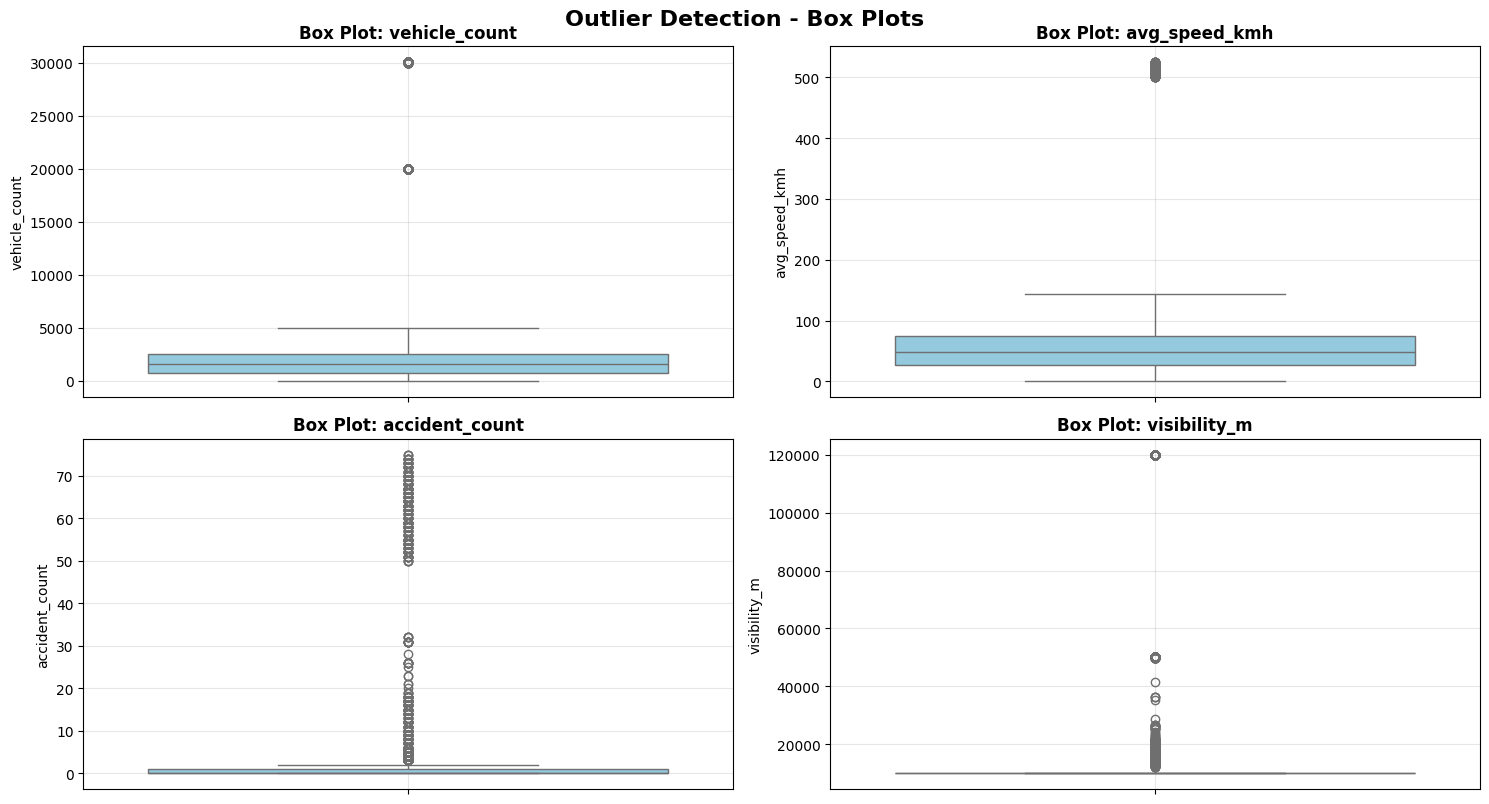

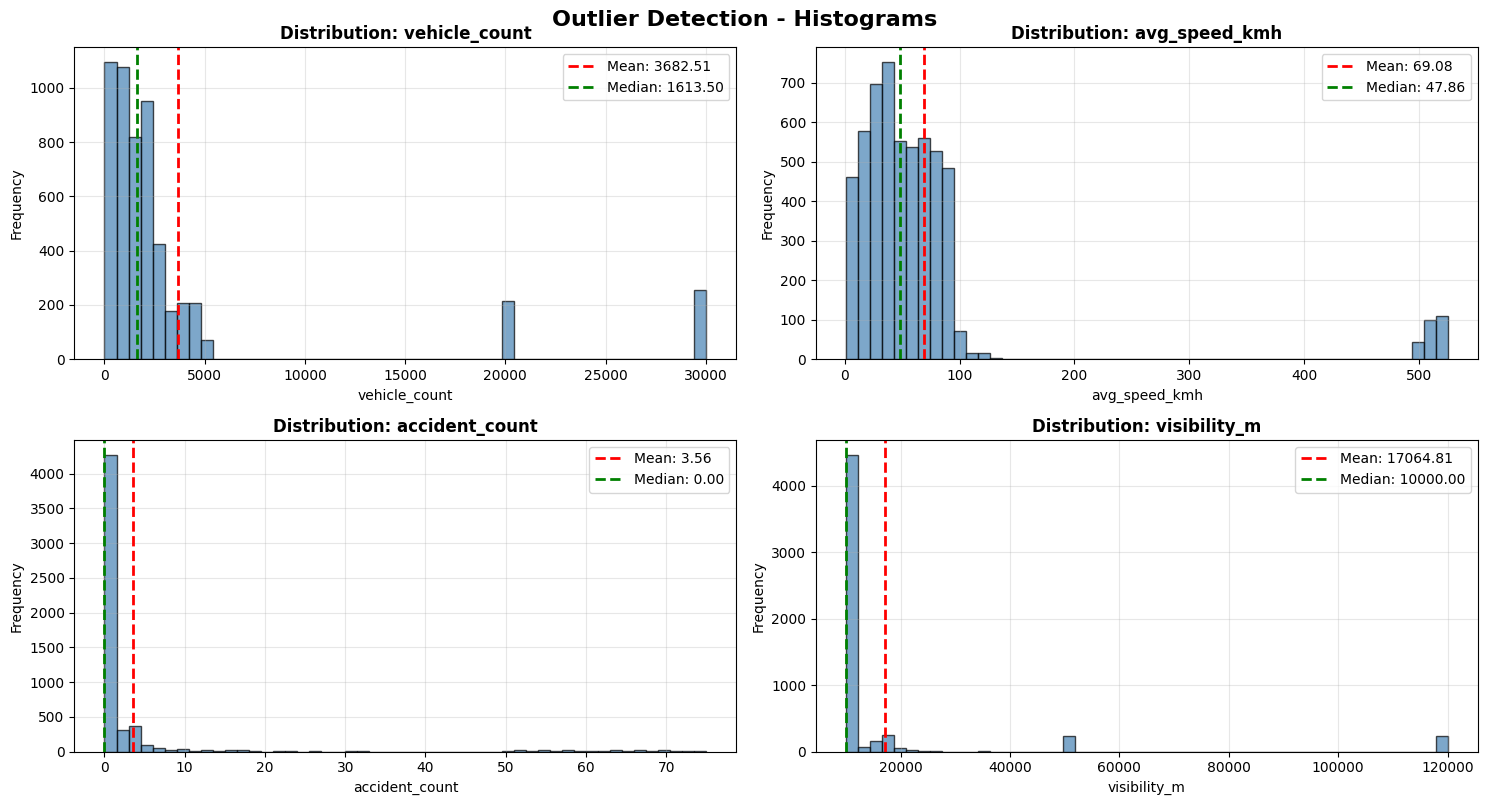

In [35]:
# Define numerical features
numerical_features = ['vehicle_count','avg_speed_kmh', 'accident_count', 'visibility_m']

print("="*80)
print("OUTLIER DETECTION ANALYSIS")
print("="*80)

# Statistical outlier detection using IQR and Z-score
outlier_summary = []

for col in numerical_features:
    print(f"\n{'='*80}")
    print(f"Feature: {col}")
    print(f"{'='*80}")
    
    data = df_stage_12[col].dropna()
    
    # Basic statistics
    print(f"\nBasic Statistics:")
    print(f"  Mean: {data.mean():.2f}")
    print(f"  Median: {data.median():.2f}")
    print(f"  Std Dev: {data.std():.2f}")
    print(f"  Min: {data.min():.2f}")
    print(f"  Max: {data.max():.2f}")
    
    # IQR Method
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_iqr = data[(data < lower_bound) | (data > upper_bound)]
    outlier_pct_iqr = (len(outliers_iqr) / len(data)) * 100
    
    print(f"\nIQR Method:")
    print(f"  Q1: {Q1:.2f}")
    print(f"  Q3: {Q3:.2f}")
    print(f"  IQR: {IQR:.2f}")
    print(f"  Lower Bound: {lower_bound:.2f}")
    print(f"  Upper Bound: {upper_bound:.2f}")
    print(f"  Number of Outliers: {len(outliers_iqr)} ({outlier_pct_iqr:.2f}%)")
    
    # Store summary
    outlier_summary.append({
        'Feature': col,
        'IQR_Outliers': len(outliers_iqr),
        'IQR_Percentage': outlier_pct_iqr,
        'Has_Outliers': 'Yes' if len(outliers_iqr) > 0 else 'No'
    })

# Create summary dataframe
summary_df = pd.DataFrame(outlier_summary)
print(f"\n{'='*80}")
print("OUTLIER SUMMARY")
print(f"{'='*80}\n")
print(summary_df.to_string(index=False))

# Visual Analysis
n_features = len(numerical_features)
n_cols = 2
n_rows = (n_features + 1) // 2

# 1. Box plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, col in enumerate(numerical_features):
    sns.boxplot(data=df_stage_12, y=col, ax=axes[idx], color='skyblue')
    axes[idx].set_title(f'Box Plot: {col}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(col)
    axes[idx].grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(len(numerical_features), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.suptitle('Outlier Detection - Box Plots', fontsize=16, fontweight='bold', y=1.00)
plt.show()

# 2. Histograms with distribution
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, col in enumerate(numerical_features):
    data = df_stage_12[col].dropna()
    axes[idx].hist(data, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx].axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.2f}')
    axes[idx].axvline(data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {data.median():.2f}')
    axes[idx].set_title(f'Distribution: {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(len(numerical_features), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.suptitle('Outlier Detection - Histograms', fontsize=16, fontweight='bold', y=1.00)
plt.show()

## Handling outliers using IQR Winsorizing method

In [36]:
# Create a copy of the dataframe
fully_cleaned_df = df_stage_12.copy()

print("="*80)
print("HANDLING OUTLIERS USING IQR WINSORIZING")
print("="*80)

# Apply IQR Winsorizing to each feature
for col in numerical_features:
    # Calculate IQR bounds
    Q1 = fully_cleaned_df[col].quantile(0.25)
    Q3 = fully_cleaned_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers before winsorizing
    outliers_lower = len(fully_cleaned_df[fully_cleaned_df[col] < lower_bound])
    outliers_upper = len(fully_cleaned_df[fully_cleaned_df[col] > upper_bound])
    total_outliers = outliers_lower + outliers_upper
    
    # Winsorize: cap values at the bounds
    fully_cleaned_df[col] = np.where(fully_cleaned_df[col] < lower_bound, 
                                     lower_bound, 
                                     fully_cleaned_df[col])
    fully_cleaned_df[col] = np.where(fully_cleaned_df[col] > upper_bound, 
                                     upper_bound, 
                                     fully_cleaned_df[col])
    
    print(f"\n{col}:")
    print(f"  Lower Bound: {lower_bound:.2f}")
    print(f"  Upper Bound: {upper_bound:.2f}")
    print(f"  Outliers capped at lower bound: {outliers_lower}")
    print(f"  Outliers capped at upper bound: {outliers_upper}")
    print(f"  Total outliers handled: {total_outliers}")

print("\n" + "="*80)
print("IQR WINSORIZING COMPLETE")
print("="*80)
print(f"\nDataframe shape: {fully_cleaned_df.shape}")
print(f"All outliers have been capped at IQR bounds")
print(f"\nFirst few rows:")
print(fully_cleaned_df[numerical_features].head())

HANDLING OUTLIERS USING IQR WINSORIZING

vehicle_count:
  Lower Bound: -1929.62
  Upper Bound: 5189.38
  Outliers capped at lower bound: 0
  Outliers capped at upper bound: 472
  Total outliers handled: 472

avg_speed_kmh:
  Lower Bound: -44.88
  Upper Bound: 145.67
  Outliers capped at lower bound: 0
  Outliers capped at upper bound: 248
  Total outliers handled: 248

accident_count:
  Lower Bound: -1.50
  Upper Bound: 2.50
  Outliers capped at lower bound: 0
  Outliers capped at upper bound: 911
  Total outliers handled: 911

visibility_m:
  Lower Bound: 10000.00
  Upper Bound: 10000.00
  Outliers capped at lower bound: 0
  Outliers capped at upper bound: 1033
  Total outliers handled: 1033

IQR WINSORIZING COMPLETE

Dataframe shape: (5500, 10)
All outliers have been capped at IQR bounds

First few rows:
   vehicle_count  avg_speed_kmh  accident_count  visibility_m
0          390.0      78.737236             0.0       10000.0
1           49.0     124.040482             2.5       1000

## Checking that outliers are removed statitically and graphically

OUTLIER DETECTION ANALYSIS

Feature: vehicle_count

Basic Statistics:
  Mean: 1945.95
  Median: 1613.50
  Std Dev: 1530.84
  Min: 0.00
  Max: 5189.38

IQR Method:
  Q1: 740.00
  Q3: 2519.75
  IQR: 1779.75
  Lower Bound: -1929.62
  Upper Bound: 5189.38
  Number of Outliers: 0 (0.00%)

Feature: avg_speed_kmh

Basic Statistics:
  Mean: 52.54
  Median: 47.86
  Std Dev: 33.28
  Min: 1.02
  Max: 145.67

IQR Method:
  Q1: 26.58
  Q3: 74.22
  IQR: 47.64
  Lower Bound: -44.88
  Upper Bound: 145.67
  Number of Outliers: 0 (0.00%)

Feature: accident_count

Basic Statistics:
  Mean: 0.58
  Median: 0.00
  Std Dev: 0.99
  Min: 0.00
  Max: 2.50

IQR Method:
  Q1: 0.00
  Q3: 1.00
  IQR: 1.00
  Lower Bound: -1.50
  Upper Bound: 2.50
  Number of Outliers: 0 (0.00%)

Feature: visibility_m

Basic Statistics:
  Mean: 10000.00
  Median: 10000.00
  Std Dev: 0.00
  Min: 10000.00
  Max: 10000.00

IQR Method:
  Q1: 10000.00
  Q3: 10000.00
  IQR: 0.00
  Lower Bound: 10000.00
  Upper Bound: 10000.00
  Number of O

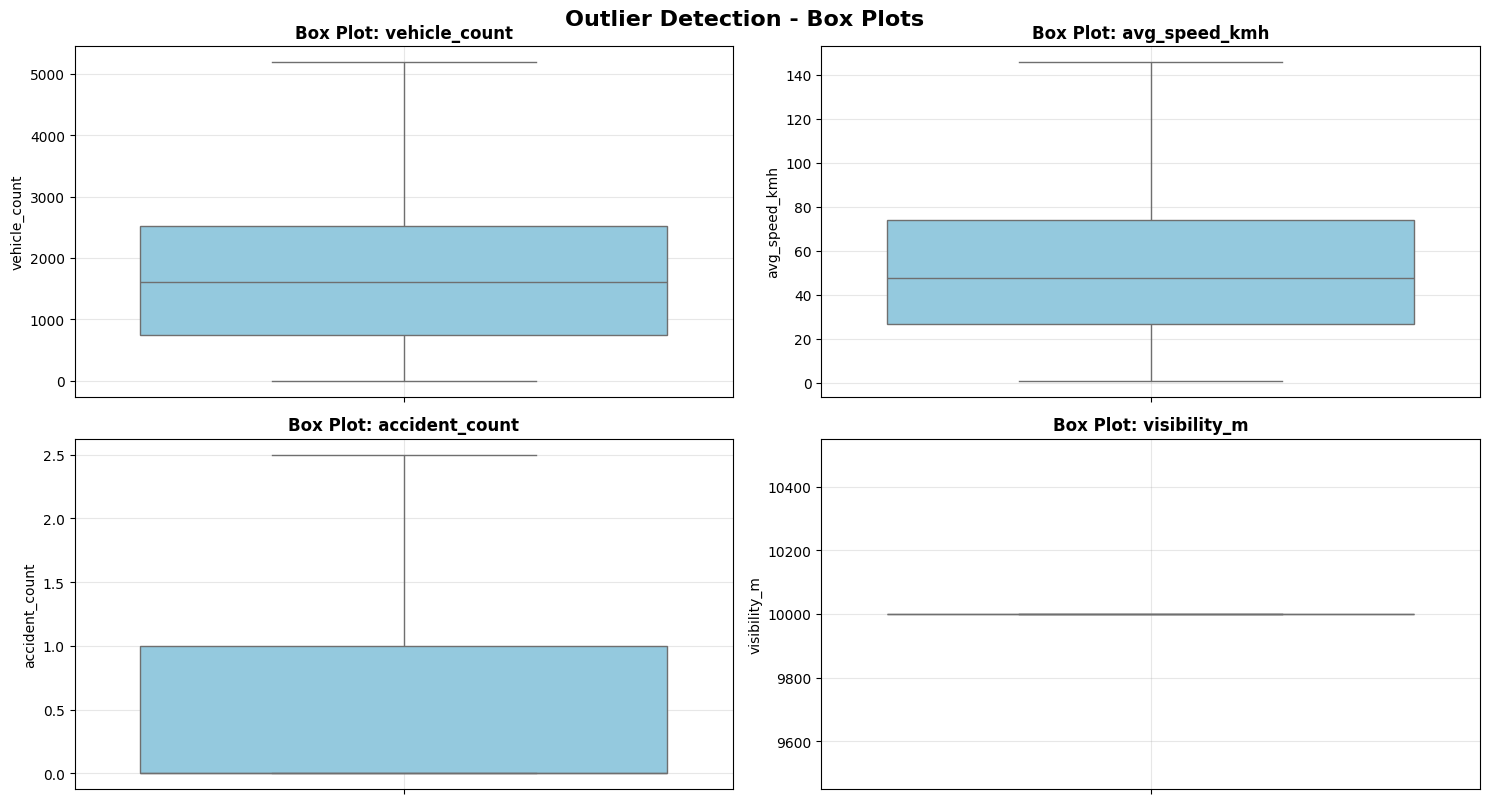

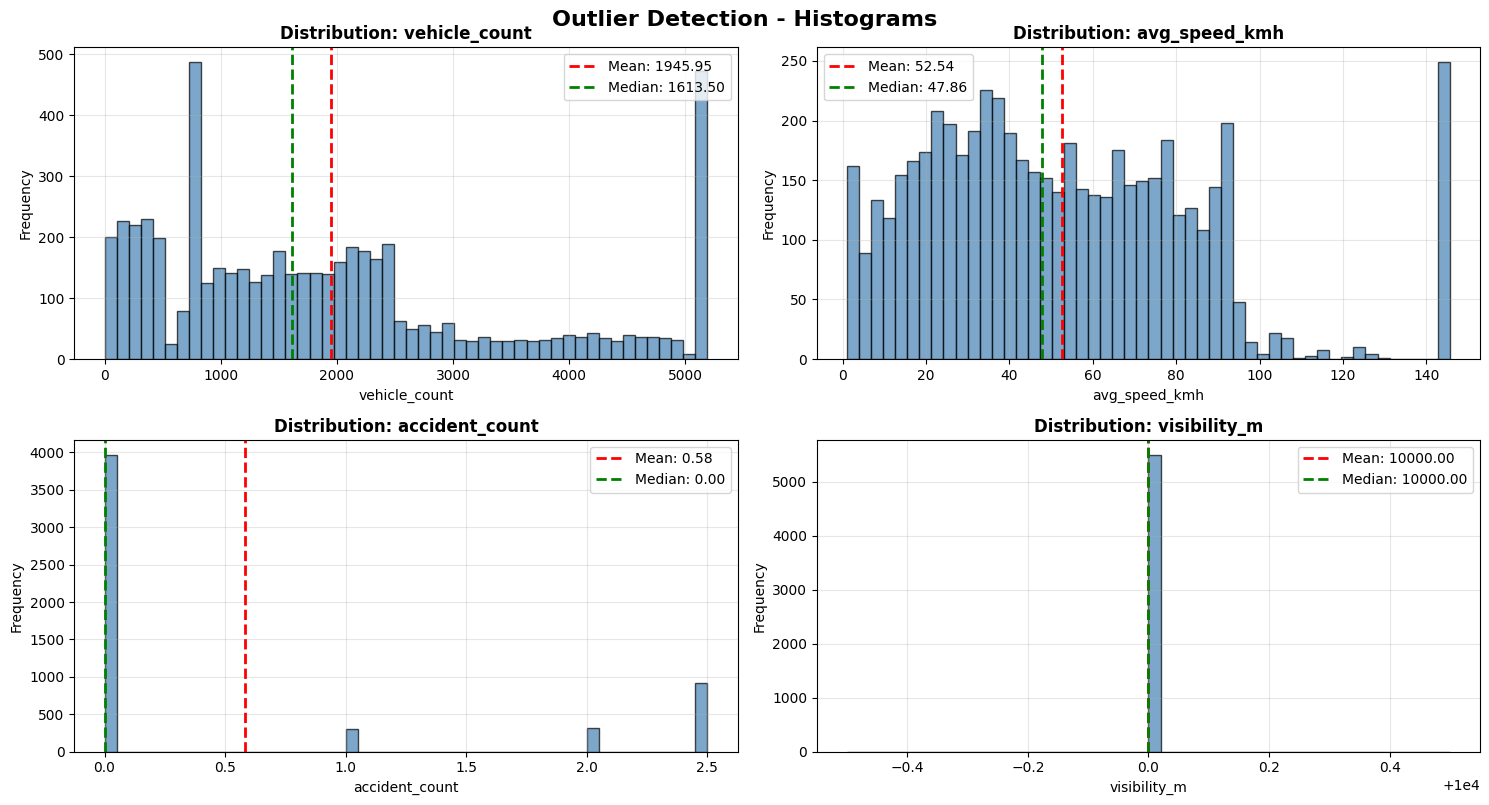

In [37]:
print("="*80)
print("OUTLIER DETECTION ANALYSIS")
print("="*80)

# Statistical outlier detection using IQR
outlier_summary = []

for col in numerical_features:
    print(f"\n{'='*80}")
    print(f"Feature: {col}")
    print(f"{'='*80}")
    
    data = fully_cleaned_df[col].dropna()
    
    # Basic statistics
    print(f"\nBasic Statistics:")
    print(f"  Mean: {data.mean():.2f}")
    print(f"  Median: {data.median():.2f}")
    print(f"  Std Dev: {data.std():.2f}")
    print(f"  Min: {data.min():.2f}")
    print(f"  Max: {data.max():.2f}")
    
    # IQR Method
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_iqr = data[(data < lower_bound) | (data > upper_bound)]
    outlier_pct_iqr = (len(outliers_iqr) / len(data)) * 100
    
    print(f"\nIQR Method:")
    print(f"  Q1: {Q1:.2f}")
    print(f"  Q3: {Q3:.2f}")
    print(f"  IQR: {IQR:.2f}")
    print(f"  Lower Bound: {lower_bound:.2f}")
    print(f"  Upper Bound: {upper_bound:.2f}")
    print(f"  Number of Outliers: {len(outliers_iqr)} ({outlier_pct_iqr:.2f}%)")
    
    # Store summary
    outlier_summary.append({
        'Feature': col,
        'IQR_Outliers': len(outliers_iqr),
        'IQR_Percentage': outlier_pct_iqr,
        'Has_Outliers': 'Yes' if len(outliers_iqr) > 0 else 'No'
    })

# Create summary dataframe
summary_df = pd.DataFrame(outlier_summary)
print(f"\n{'='*80}")
print("OUTLIER SUMMARY")
print(f"{'='*80}\n")
print(summary_df.to_string(index=False))

# Visual Analysis
n_features = len(numerical_features)
n_cols = 2
n_rows = (n_features + 1) // 2

# 1. Box plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, col in enumerate(numerical_features):
    sns.boxplot(data=fully_cleaned_df, y=col, ax=axes[idx], color='skyblue')
    axes[idx].set_title(f'Box Plot: {col}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(col)
    axes[idx].grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(len(numerical_features), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.suptitle('Outlier Detection - Box Plots', fontsize=16, fontweight='bold', y=1.00)
plt.show()

# 2. Histograms with distribution
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, col in enumerate(numerical_features):
    data = fully_cleaned_df[col].dropna()
    axes[idx].hist(data, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx].axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.2f}')
    axes[idx].axvline(data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {data.median():.2f}')
    axes[idx].set_title(f'Distribution: {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(len(numerical_features), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.suptitle('Outlier Detection - Histograms', fontsize=16, fontweight='bold', y=1.00)
plt.show()

# <div style="background:#f2f2f2; padding:12px; border-left:5px solid #4a90e2;">
#  <h3>📌 Data set is fully cleaned </h3>
# </div>

In [ ]:
%pip install pyarrow s3fs

In [39]:
import s3fs

# 1. Save a local copy (Optional, but good for verification)
fully_cleaned_df.to_parquet("../data/cleaned/traffic_cleaned.parquet", index=False, engine="pyarrow")
print("Saved locally as 'traffic_cleaned.parquet'")

# 2. Save directly to MinIO Silver Bucket (Required for Phase 2)
# Define connection details for your dockerized MinIO
minio_options = {
    "key": "admin",             # From your docker-compose.yml
    "secret": "password123",    # From your docker-compose.yml
    "client_kwargs": {
        "endpoint_url": "http://localhost:9000"
    }
}

# Write to the 'silver' bucket using the s3:// protocol
try:
    fully_cleaned_df.to_parquet(
        "s3://silver/traffic_cleaned.parquet", 
        storage_options=minio_options, 
        index=False
    )
    print("Success! Uploaded to MinIO Silver bucket.")
except Exception as e:
    print(f"Upload failed: {e}")

Saved locally as 'traffic_cleaned.parquet'
Success! Uploaded to MinIO Silver bucket.
